In [1]:
import pandas as pd 
import torch 
import torch.nn as nn 
import os 
from glob import glob 
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [11]:
! unzip /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
   creating: Traffic Data/
  inflating: __MACOSX/._Traffic Data  
   creating: Traffic Data/train/
  inflating: __MACOSX/Traffic Data/._train  
   creating: Traffic Data/validation/
  inflating: __MACOSX/Traffic Data/._validation  
   creating: Traffic Data/train/images/
  inflating: __MACOSX/Traffic Data/train/._images  
   creating: Traffic Data/train/labels/
  inflating: __MACOSX/Traffic Data/train/._labels  
   creating: Traffic Data/validation/images/
  inflating: __MACOSX/Traffic Data/validation/._images  
   creating: Traffic Data/validation/labels/
  inflating: __MACOSX/Traffic Data/validation/._labels  
  inflating: Traffic Data/train/images/00654.jpg  
  inflating: __MACOSX/Traffic Data/train/images/._00654.jpg  
  inflating: Traffic Data/train/images/00640.jpg  
  inflating: __MACOSX/Traffic Data/train/images/._00640.jpg  
  inflating: Traffic Data/train/images/00126.jpg  
  inflating: __MACOSX/Traffic Data/train/images/._00126.jpg  

In [3]:
train_images_path = '/content/Traffic Data/train/images'
train_label_path = '/content/Traffic Data/train/labels'
val_images_path = '/content/Traffic Data/validation/images'
val_label_path = '/content/Traffic Data/validation/labels'

In [4]:
# !pip install super-gradients==3.1.0
# !pip install imutils

# !pip install roboflow

# !pip install pytube --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyparsing-2.4.5-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.0.8 requires pyparsing==2.4.7, but you have pyparsing 2.4.5 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.5
    Uninstalling pyparsing-2.4.5:
      Successfully uninstalled pyparsing-2.4.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
super-gradients 3.1.0 requires pyparsing==2.4.5, but you have pyparsing 2.4.7 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
torch.__version__

'1.13.1+cu117'

In [6]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

In [7]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)


[2023-05-12 10:48:14] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-12 10:48:18] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-12 10:48:18] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-12 10:48:18] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-12 10:48:18] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [12]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val


In [13]:
dataset_params = {
    'data_dir':'/content/Traffic Data',
    'train_images_dir': train_images_path,
    'train_labels_dir':train_label_path,
    'val_images_dir':val_images_path,
    'val_labels_dir':val_label_path,
    'classes': ["prohibitory", "danger","mandatory","other"]
                            }

In [14]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)




clear_output()

In [15]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [16]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [17]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

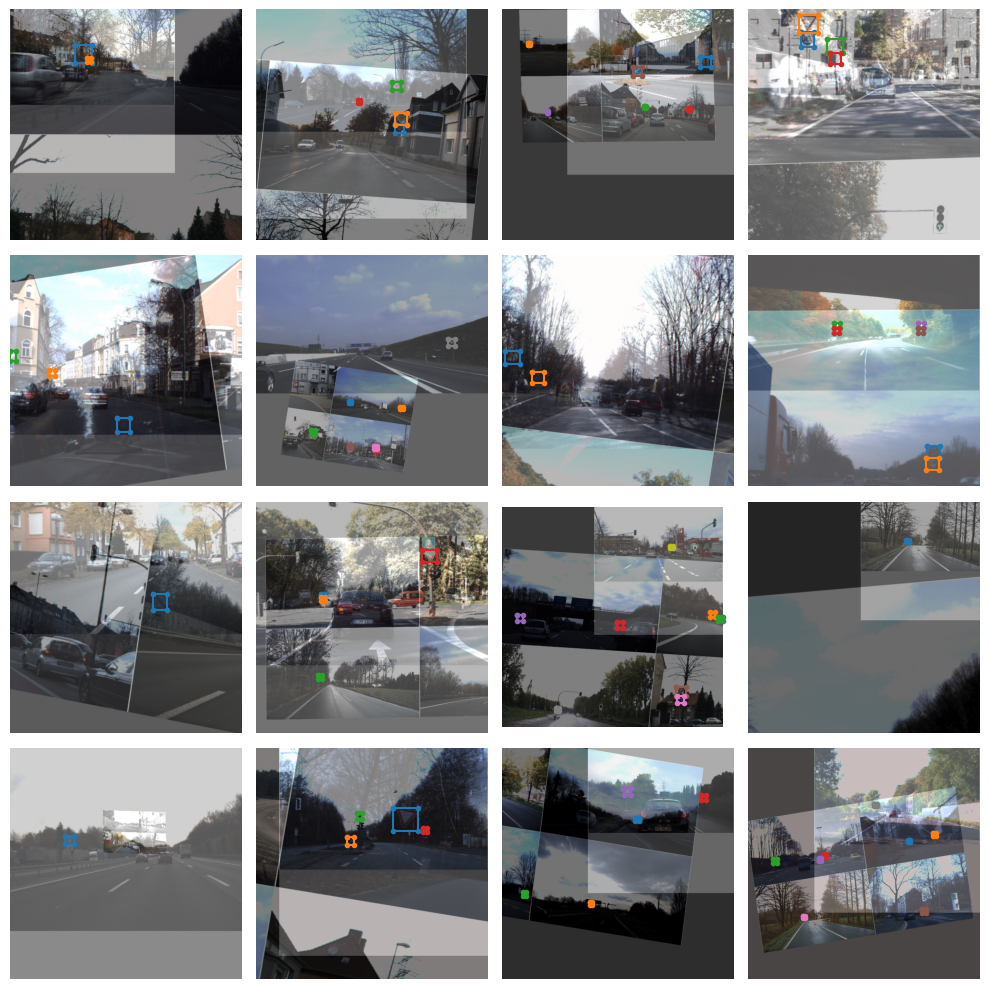

In [18]:
train_data.dataset.plot()

In [19]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-12 10:49:33] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


In [24]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'device' : 'cuda',
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [25]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-12 10:58:34] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yolonas_run/console_May12_10_58_34.txt


[2023-05-12 10:58:43] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 592        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         37         (len(train_loader))
    - Gradient updates per epoch:   37         (len(train_loader) / batch_accumulate)

[2023-05-12 11:00:24] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-12 11:00:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8748041391372681
[2023-05-12 11:02:10] INFO - base_sg_logger.py - Checkpoint saved in che

SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.294
│   │   ├── Best until now = 1.3166 (↘ -0.0227)
│   │   └── Epoch N-1      = 1.3166 (↘ -0.0227)
│   ├── Ppyoloeloss/loss_cls = 0.6444
│   │   ├── Best until now = 0.6629 (↘ -0.0186)
│   │   └── Epoch N-1      = 0.6629 (↘ -0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.597
│   │   ├── Best until now = 0.6022 (↘ -0.0052)
│   │   └── Epoch N-1      = 0.6022 (↘ -0.0052)
│   └── Ppyoloeloss/loss_iou = 0.1405
│       ├── Best until now = 0.141  (↘ -0.0006)
│       └── Epoch N-1      = 0.141  (↘ -0.0006)
└── Validation
    ├── F1@0.50 = 0.1531
    │   ├── Best until now = 0.2978 (↘ -0.1447)
    │   └── Epoch N-1      = 0.1731 (↘ -0.02)
    ├── Map@0.50 = 0.9362
    │   ├── Best until now = 0.9355 (↗ 0.0007)
    │   └── Epoch N-1      = 0.9355 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1.1085
    │   ├── Best until now = 0.3539 (↗ 0.7547)
    │   └── Epoch N-1      = 1.0786 (↗ 0.03)
    ├── Ppyoloeloss/loss_cls = 0.5899
    │   ├── Best un

In [26]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/ckpt_best.pth")

[2023-05-12 11:17:49] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


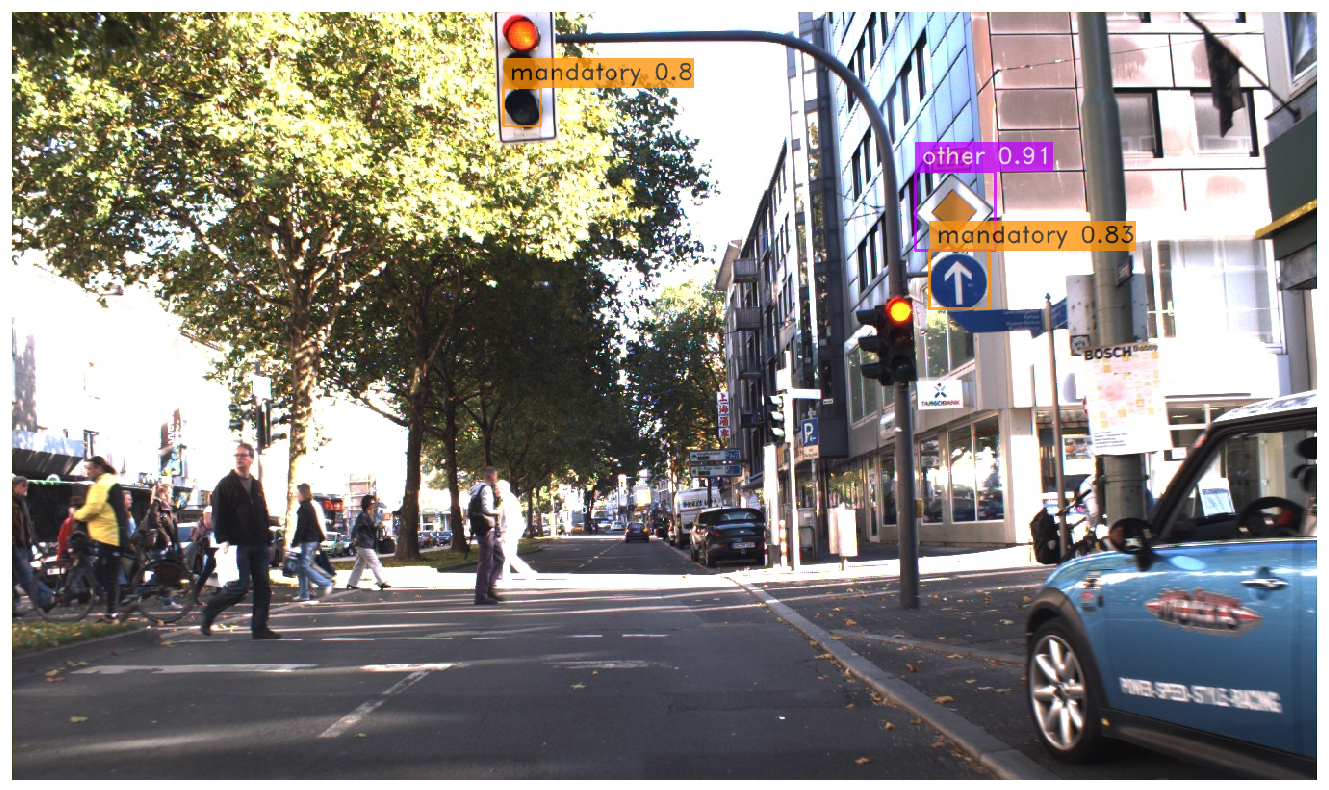

In [28]:
test_image = '/content/Traffic Data/validation/images/00039.jpg'
best_model.predict(test_image).show()